In [1]:
# import packages
import re,os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from IPython.display import clear_output
import pandas as pd
import math
import random
from datetime import datetime
tfk = tf.keras
tfkl = tf.keras.layers
clear_output()
# import my files
from MRA_generate import MRA_generate
from symae_model import SymAE
from parameters import *
from plot_training import plot_training
from plot_redatuming import plot_redatuming
from plot_save import plot_save
from CustomCallback import CustomCallback
from redatuming import redatuming
from latent import latent

Num GPUs Available:  2
TensorFlow Version:  2.9.1


In [2]:
# Generate the Dataset
ne=3
def g(n,x):
    if n==0:
        return math.cos(2*math.pi*x)
    elif n==1:
        if x<0.5:
            return 1
        else:
            return 0
    elif n==2:
        return math.e**(-9*x**2)
    else:
        return np.inf
MRA_data=MRA_generate(d,nt,N,sigma,ne,g)
X=MRA_data.X
print("Numbers of States:")
pd.DataFrame(MRA_data.states).value_counts()

Numbers of States:


1    343
0    336
2    321
dtype: int64

In [3]:
# Initialize SymAE
model=SymAE(N,nt,d,p,q,kernel_size,filters,dropout_rate)
Adam=tf.keras.optimizers.Adam(learning_rate=0.001,beta_1=0.9,beta_2=0.999,epsilon=1e-07)
SGD=tf.keras.optimizers.SGD(learning_rate=0.1,momentum=0.9,nesterov=True)
model.compile(loss='mse',optimizer=Adam)
#model.load_weights('./checkpoints/'+datetime.now().strftime("%B%d"))
clear_output()

In [4]:
# Train the NeuralNet
M=500
epochs=range(M)
losses=[0.0]*M
class CustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        losses[epoch]=logs["loss"]
        print("For epoch {:d}, loss is {:f}.".format(epoch, logs["loss"]))
history=model.fit(X,X,epochs=M,verbose=0,callbacks=[CustomCallback()])

For epoch 499, loss is 0.033201.


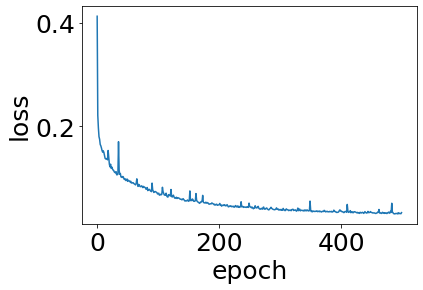

In [14]:
plt.plot(epochs,losses)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

1/1 [==============================] - 0s 35ms/step


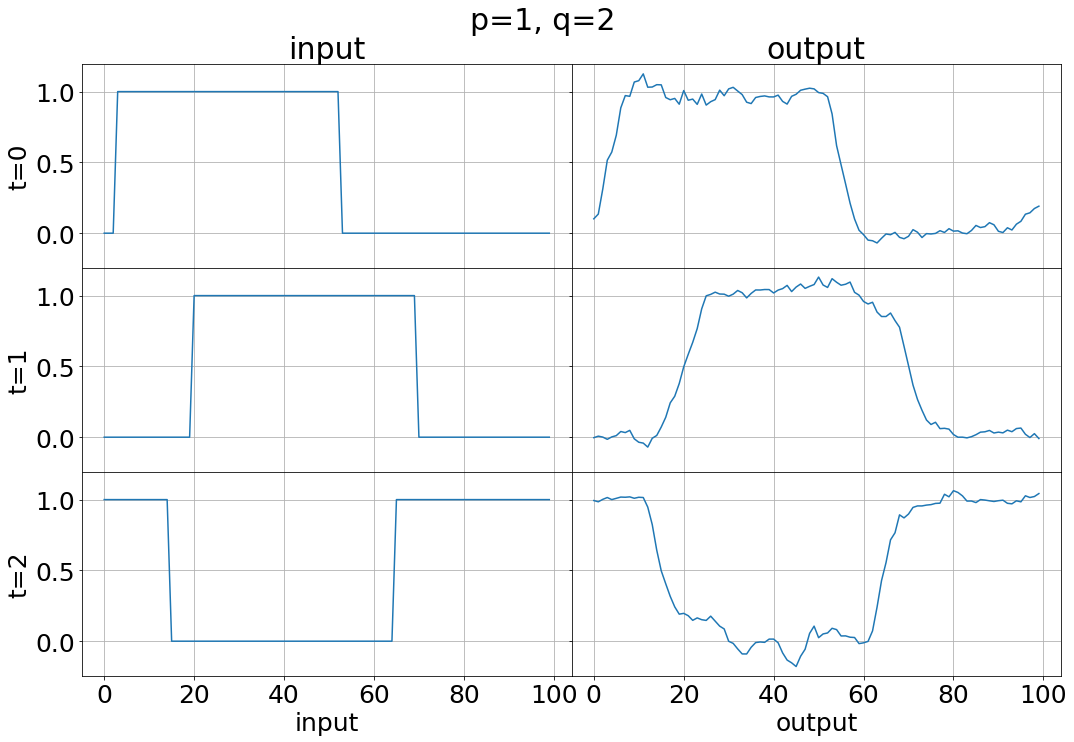

In [15]:
# Plot the result
def find_state(state):
    MRA_data=MRA_generate(d,nt,1,sigma,ne,g)
    for i in range(100):
        MRA_data.generate_default()
        if MRA_data.states[0]==state:
            return MRA_data
test_X=find_state(1).X
fig=plot_training(model,test_X)

In [16]:
# Save weights
model.save_weights('./checkpoints/'+datetime.now().strftime("%B%d"))
print("weights saved")

weights saved


In [18]:
# Save plot
plot_save(fig,ID=-1)

Saved as plot_54.png


The MSE of C1N2 is: 0.455888
The MSE of C2N1 is: 0.260370


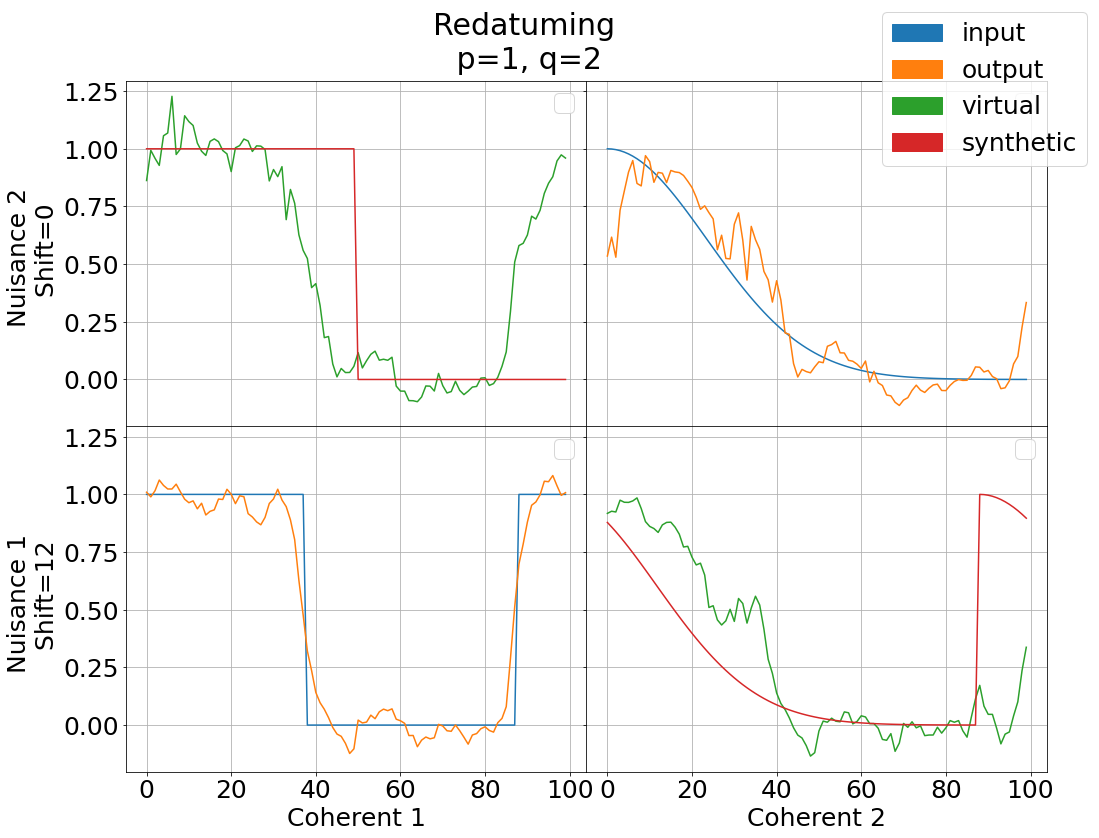

In [19]:
# Redatuming
MRA1=find_state(1)
MRA2=find_state(2)
t=1
redatum=redatuming(model,MRA1,MRA2,t)
MSE_C1_N2,MSE_C2_N1=redatum.MSE()
fig=plot_redatuming(redatum)
clear_output()
print('The MSE of C1N2 is: %f'%MSE_C1_N2)
print('The MSE of C2N1 is: %f'%MSE_C2_N1)

In [10]:
# Save plot
plot_save(fig,ID=-1)

Saved as plot_51.png


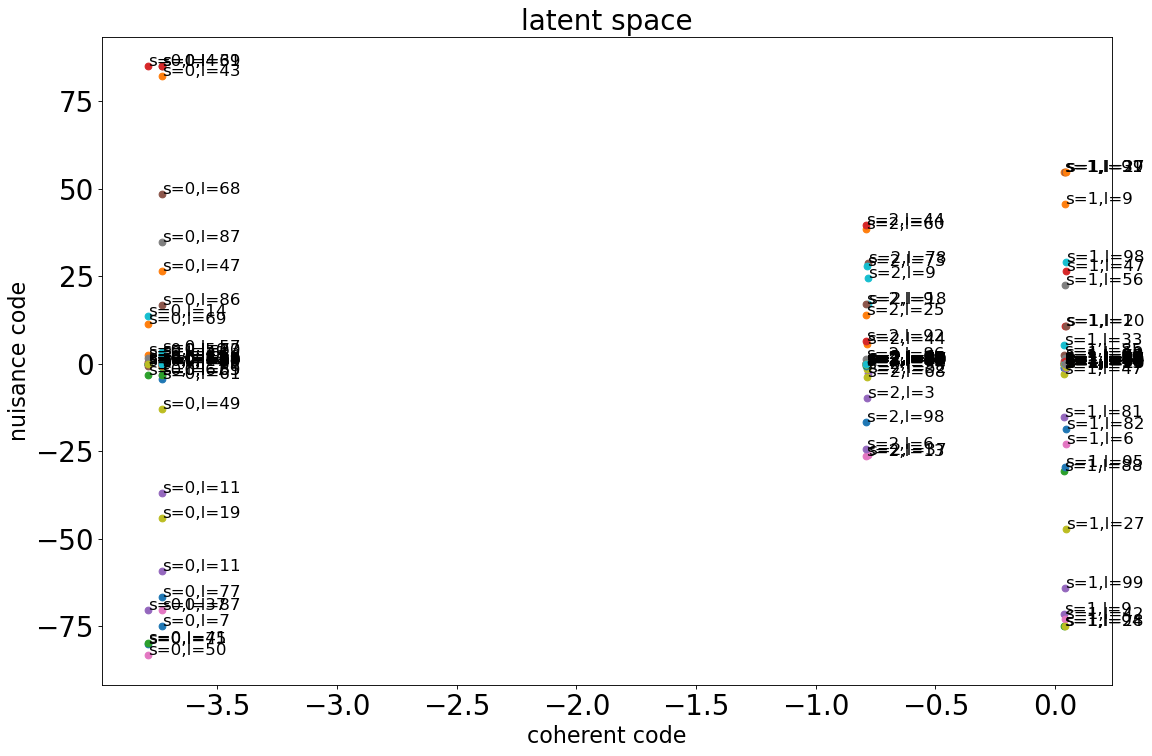

In [23]:
# What's the information in latent space?
fig=plt.figure(figsize=(15, 10), dpi=80)
plt.xlabel('coherent code',fontsize=20)
plt.ylabel('nuisance code',fontsize=20)
plt.title('latent space',fontdict = {'fontsize' : 25})
for s in list(range(ne))*3:
    MRA=find_state(s)
    C,N=latent(model,MRA)
    for i in range(nt):
        plt.scatter(C[0],N[i])
        plt.text(C[0],N[i],"s=%d,l=%d"%(MRA.states[0],MRA.shifts[0,i]),fontsize=15)
#plt.xlim([-10,8])
#plt.ylim([-1,1])
clear_output()
plt.tight_layout()

In [12]:
# Save plot
plot_save(fig,ID=-1)

Saved as plot_52.png
